<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-файла-с-данными" data-toc-modified-id="Изучение-файла-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение файла с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LightGBMClassifier" data-toc-modified-id="LightGBMClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBMClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

<b>Описание проекта</b>  

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Значение метрики *F1* на должно быть не меньше 0.75. 

**Нам надо:**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделайть выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Изучение файла с данными

In [1]:
# Импортируем библиотеки
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer                         
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV,
                                     TimeSeriesSplit,
                                     train_test_split)
from sklearn.metrics import f1_score

from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ksu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ksu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ksu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# загружаем и выводим данные
data = pd.read_csv(r'https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [3]:
# Изучим общую информацию о полученном датафрейме
display(data.info(), data.sample(10), 
        data.describe(include='all').round(2),        
        data.isna().sum(), data.shape)                                    
print('Количество дупликатов:', data.duplicated().sum()) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
58943,"Jack and Jill \nEric, thank you for your contr...",1
89941,Well I like to stay true to my userboxes !). I...,0
24738,"""In addition, your IP address will no longer b...",0
13765,"""\n\nFound something already- Livingstone clai...",0
101063,"""\n\nMEAN SPRITED DUMB ASSES\nI HOPE YOU GET T...",1
69125,It was an old convo \n\nThat conversation is p...,1
100894,is gay because he is against anonymous,1
9420,I don't know if you are aware but sending e-ma...,0
93268,"""\nNot to get off topic (or on topic), but I *...",0
85351,"Yes, England and Wales has something like it, ...",0


,text,toxic
count,159292,159292.0
unique,159292,NaN
top,Explanation\nWhy the edits made under my usern...,NaN
freq,1,NaN
mean,NaN,0.1
std,NaN,0.3
min,NaN,0.0
25%,NaN,0.0
50%,NaN,0.0
75%,NaN,0.0


text     0
toxic    0
dtype: int64

(159292, 2)

Количество дупликатов: 0


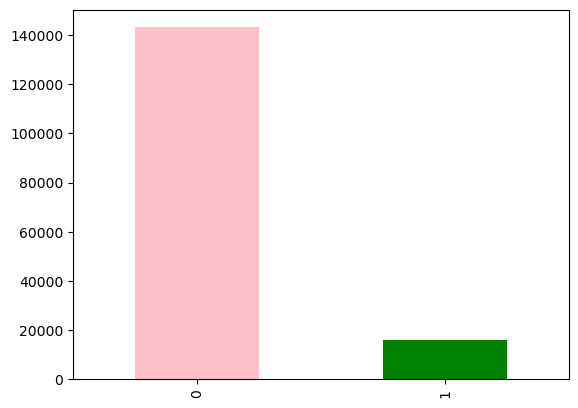

In [4]:
# Построим график для столбца 'toxic'
data['toxic'].value_counts().plot(kind='bar', color=['pink', 'green']);

In [5]:
# Получим количество каждого значения для столбца 'toxic' в %
round(data['toxic'].value_counts(normalize=True)*100, 2)

0    89.84
1    10.16
Name: toxic, dtype: float64

В таблице 2 столбца и 159292 строк. Пропуски и явные дупликаты отсутствуют. В нашей таблице позитивных записей около 90% , токсичных чуть больше 10%. Можно сказать, что имеется дисбаланс данных.

## Предобработка данных

В текстах использованы как нижний, так и верхний регистры. Приведем тексты к нижнему регистру.

In [6]:
data['text'] = data['text'].apply(lambda x: x.lower())

Предобработаем записи в столбце 'text'. Упростим их: разобьем текст на токены, удалим стоп слова и приведем слова к начальной форме. 

In [7]:
def get_wordnet_pos_func(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Создадим функцию обработки текстов
def data_preprocessing(text):
    # Оставим только слова
    text =  re.sub('[^A-Za-z0-9]+', ' ', text) 
    # Конвертируем тексты в токены
    tokens = word_tokenize(text) 
    # Убираем стоп слова
    text = [word for word in tokens if word not in stop_words] 
    # Лемматизируем текст
    text = [lemmatizer.lemmatize(word, get_wordnet_pos_func(word)) for word in tokens]
    # Объединим слова в обработанных текстах
    text = ' '.join(text)
    
    return text

In [9]:
# Применим функцию
data['text'] = data['text'].progress_apply(lambda text: data_preprocessing(text))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
# Проверим изменения
display(data.head())

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Построим облако слов

In [11]:
# Объединим слова в обработанных текстах
text_raw = ' '.join(data['text'])

In [12]:
# Функция для визуализации облака слов
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud) 
    plt.axis("off")
    

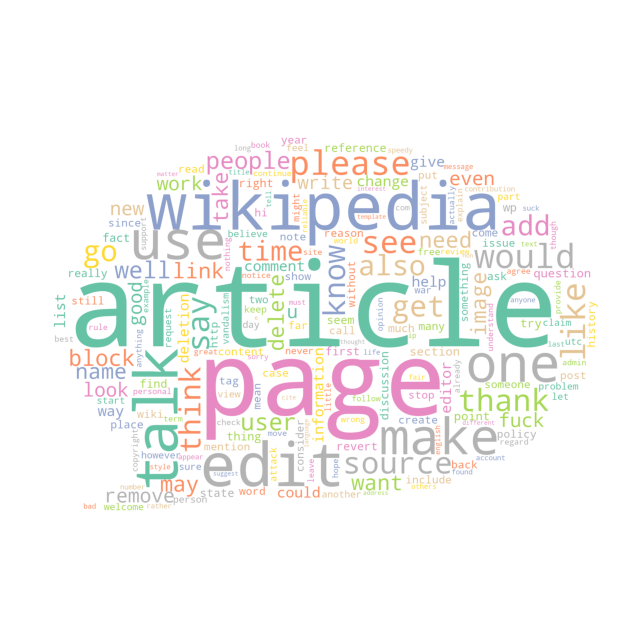

In [13]:
# Превращаем картинку в маску
mask = np.array(Image.open(r'C:\Users\Ksu\Desktop\проекты\comment.png'))

# Генерируем облако слов
wordcloud = WordCloud(width = 500, 
                      height = 100, 
                      random_state=1, 
                      background_color='white', 
                      colormap='Set2', 
                      collocations=False, 
                      stopwords = stop_words,
                      mask=mask).generate(text_raw)
                      
# Выводим его на экран
plot_cloud(wordcloud)

На этапе предобработки данных мы привели записи в столбце 'text' к нижнему регистру и подготовили их для дальнейшего обучения моделей.

## Обучение

In [14]:
# Разобьем данные data на признаки и целевой признак, сохраним в отдельных переменных
features = data.drop('toxic', axis=1)
target = data.toxic

In [15]:
# Разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42, stratify=target) 

In [18]:
# Проверим размеры выборок
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119469, 1)
(39823, 1)
(119469,)
(39823,)


In [28]:
features_train = X_train.text
features_test = X_test.text

Для обучения моделей применим следующие библиотеки: LogisticRegression, RandomForestClassifier и LightGBMClassifier.

### LogisticRegression

In [35]:
%%time
model_lr = LogisticRegression(class_weight='balanced', random_state=42)

# Создадим пайплайн
pipeline_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                       ('logisticregression', model_lr)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lr = {'logisticregression__solver':['lbfgs', 'liblinear']}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lr = RandomizedSearchCV(estimator=pipeline_lr, 
                           param_distributions=param_grid_lr, 
                           scoring='f1',
                           cv=5,
                           n_iter=20,
                           n_jobs=-1, 
                           random_state=42,
                           verbose=10)

random_cv_lr.fit(features_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 7.53 s
Wall time: 21.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words='english')),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__solver': ['lbfgs',
                                                                       'liblinear']},
                   random_state=42, scoring='f1', verbose=10)

In [40]:
random_cv_lr_best_score = random_cv_lr.best_score_.round(2) 
random_cv_lr_best_params = random_cv_lr.best_params_

# Лучшее значение метрики F1 
print(f'best_score: {random_cv_lr_best_score}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_lr_best_params}')

best_score: 0.74
best_params: {'logisticregression__solver': 'lbfgs'}


In [63]:
# Проверим результаты на тестовой выборке
predictions_test_lr = random_cv_lr.predict(features_test)
f1_lr = round(f1_score(y_test, predictions_test_lr),2)
print('Метрика F1 на тестовой выборке для модели LogisticRegression составила:', f1_lr)

Метрика F1 на тестовой выборке для модели LogisticRegression составила: 0.75


### RandomForestClassifier

In [42]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state = 42)

# Создадим пайплайн
pipeline_rf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                        ('randomforestclassifier', model_rf)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_rf = {'randomforestclassifier__n_estimators': range(2, 51, 2),
                 'randomforestclassifier__max_depth': range(2, 15),
                 'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)}
                                  
# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_rf = RandomizedSearchCV(estimator=pipeline_rf, 
                           param_distributions=param_grid_rf, 
                           scoring='f1_weighted',
                           cv=3,
                           n_iter=10,
                           n_jobs=-1, 
                           random_state=42,
                           verbose=10)

random_cv_rf.fit(features_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words='english')),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__n_estimators': range(2, 51, 2)},
                   random_state=42, scoring='f1_weighted', verbose=10)

In [43]:
random_cv_rf_best_score = random_cv_rf.best_score_.round(3) 
random_cv_rf_best_params = random_cv_rf.best_params_

# Лучшее значение метрики F1 
print(f'best_score: {random_cv_rf_best_score}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_rf_best_params}')

best_score: 0.769
best_params: {'randomforestclassifier__n_estimators': 40, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 14}


In [65]:
# Проверим результаты на тестовой выборке
predictions_test_rf = random_cv_rf.predict(features_test)
f1_rf = round(f1_score(y_test, predictions_test_rf),2)
print('Метрика F1 на тестовой выборке для модели RandomForestClassifier составила:', f1_rf)

Метрика F1 на тестовой выборке для модели RandomForestClassifier составила: 0.36


### LightGBMClassifier

In [46]:
model_lgbm = LGBMClassifier(class_weight='balanced', boosting_type='gbdt', random_state = 42)
                            
# Создадим пайплайн                        
pipeline_lgbm = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                          ('lightgbmclassifier', model_lgbm)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgbm = {'lightgbmclassifier__n_estimators': range(2, 51, 2),
                   'lightgbmclassifier__max_depth': range(2, 10),
                   'lightgbmclassifier__num_leaves': [25, 50, 100],
                   'lightgbmclassifier__learning_rate': [.1, .3, .5]}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lgbm = RandomizedSearchCV(estimator=pipeline_lgbm, 
                                    param_distributions=param_grid_lgbm, 
                                    scoring='f1',
                                    cv=3,
                                    n_iter=5,
                                    n_jobs=-1, 
                                    error_score='raise',
                                    random_state=42,
                                    verbose=10)

random_cv_lgbm.fit(features_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 12140, number of negative: 107329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.884632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521376
[LightGBM] [Info] Number of data points in the train set: 119469, number of used features: 9825
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words='english')),
                                             ('lightgbmclassifier',
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'lightgbmclassifier__learning_rate': [0.1,
                                                                              0.3,
                                                                              0.5],
                                        'lightgbmclassifier__max_depth': range(2, 10),
                                        'lightgbmclassifier__n_estimators': range(2, 51, 2),
                                        'lightgbmclassifier__num_leaves': [25,
                                                                           50,
                                                                           100]},
                   random_state=42, scoring='f1', verbose=10)

In [47]:
random_cv_lgbm_best_score = random_cv_lgbm.best_score_.round(3)
random_cv_lgbm_best_params = random_cv_lgbm.best_params_

# лучшее значение метрики F1 
print(f'best_score: {random_cv_lgbm_best_score}')
# лучшие гиперпараметры
print(f'best_params: {random_cv_lgbm_best_params}')

best_score: 0.699
best_params: {'lightgbmclassifier__num_leaves': 100, 'lightgbmclassifier__n_estimators': 24, 'lightgbmclassifier__max_depth': 5, 'lightgbmclassifier__learning_rate': 0.3}


In [66]:
# Проверим результаты на тестовой выборке
predictions_test_lgbm = random_cv_lgbm.predict(features_test)
f1_lgbm = round(f1_score(y_test, predictions_test_lgbm),2)
print('Метрика F1 на тестовой выборке для модели LGBMClassifier составила:', f1_lgbm)

Метрика F1 на тестовой выборке для модели LGBMClassifier составила: 0.7


In [67]:
# Объеденим данные в одну таблицу
result = pd.DataFrame([[random_cv_lr_best_score, f1_lr],
                       [random_cv_rf_best_score, f1_rf],
                       [random_cv_lgbm_best_score, f1_lgbm]],                      
                       index=['LogisticRegression',
                              'RandomForestClassifier',
                              'LGBMClassifier'],                              
                     columns=['F1 на тренировочной выборке', 'F1 на тестовой выборке'])      
               
result

,F1 на тренировочной выборке,F1 на тестовой выборке
LogisticRegression,0.740,0.75
RandomForestClassifier,0.769,0.36
LGBMClassifier,0.699,0.70


Наилучшей моделью стала  LogisticRegression  с максимальным значением метрики F1 на тестовой выборке - 0.75.

На этапе обучения мы разбили данные на тренировочную и тестовую выборки. Разбили данные на признаки и целевой признак, сохранили в отдельных переменных.   
Для обучения моделей мы применили следующие библиотеки:  LogisticRegression, RandomForestClassifier и LightGBMClassifier. Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения максимальной метрики F1. Наилучшей моделью стала LogisticRegression с максимальным значением метрики F1 на тестовой выборке - 0.75.

## Выводы

Было проведено исследование, чтобы обучить модель классифицировать комментарии на позитивные и негативные. Нам надо было построить модель со значением метрики F1 не меньше 0.75.  
На этапе предобработки данных привели записи в столбце 'text' к нижнему регистру и подготовили  их для дальнейшего обучения моделей.  
На этапе обучения мы разбили данные на тренировочную и тестовую выборки. Разбили данные на признаки и целевой признак, сохранили в отдельных переменных.   
Для обучения моделей мы применили следующие библиотеки: LogisticRegression, RandomForestClassifier и LightGBMClassifier. Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения максимальной метрики F1.   
По итогам анализа результатов было принято решение рекомендовать заказчику модель LogisticRegression с максимальным значением метрики F1 на тестовой выборке - 0.75.
